In [2]:
import gc
import os
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pickle
from sklearn.utils import resample
from collections import Counter
import math
from sklearn.model_selection import train_test_split
import helper
import dataset
import torch
import torch.nn as nn
from resnet1d.net1d import Net1D

In [3]:
data_files = [name for name in os.listdir('./data')]

dfs = []

for i in range(len(data_files)):
    fname = './data/' + data_files[i]
    df = pd.read_csv(fname)
    # df.columns = [x.strip().lstrip() for x in df.columns]

    dfs.append(df)

df = pd.concat(dfs, axis=0, ignore_index=True)

df.shape

(2830743, 79)

In [4]:
# Remove spaces in the front and the end of the column names for better human reading
df.columns = [x.lstrip().strip().replace('�', '-') for x in df.columns]
df.shape

(2830743, 79)

In [5]:
# replace inf values to nan
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.shape

(2827876, 79)

In [6]:
# remove this when experimenting on the whole dataset
df = resample(df, replace=False, n_samples=20000, stratify=df['Label'])

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

pca__n_components = 20

preprocessor = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("normalize", MinMaxScaler()),
    ("PCA", PCA(n_components=pca__n_components))
])

label_encoder = LabelEncoder()

In [8]:
X = df.drop(['Label'], axis=1)
y = df['Label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

# doing this since we need all labels in case there's any labels not found in test set
label_encoder.fit(y)

y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)

In [9]:
X_smote, _ = helper.smote_sampling(X_train, y_train)
X_gaussion = helper.add_gaussion(X_smote)
X_flip = helper.invert_array(X_train)

X_new = np.dstack([X_smote, X_gaussion, X_flip])
X_new = X_new.transpose((0, 2, 1))

X_new.shape

(16000, 3, 20)

In [10]:
# batch, channel, feature
X_train = np.expand_dims(X_train, axis=2).transpose((0, 2, 1))
X_train.shape

(16000, 1, 20)

In [11]:
org_dataset = dataset.NumpyDataset(X_train, y_train)
pos_dataset = dataset.NumpyDataset(X_new, y_train)

In [13]:
import time
import warnings
import optuna
from torch.utils.data import DataLoader
from pytorch_metric_learning.losses import SelfSupervisedLoss, NTXentLoss
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from models import Extractor, Projector, ExtractorMLP
from models import ExtractorMLP
from itertools import cycle
from torch.utils.tensorboard import SummaryWriter


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
warnings.filterwarnings('ignore')
verbose = False

def objective(trial: optuna.Trial):
    start_time = time.perf_counter()

    embedding_size = trial.suggest_int('embedding_size', 8, 64)

    params = {
        'embedding_size': embedding_size,
    }

    print(params)

    extractor_1d = Extractor(n_features=pca__n_components, n_channels=1, embedding_size=embedding_size).to(device)
    extractor_3d = Extractor(n_features=pca__n_components, n_channels=3, embedding_size=embedding_size).to(device)

    projector = Projector(embedding_size=embedding_size).to(device)

    lr = 1e-3
    weight_decay = 1e-4
    batch_size = 1024
    epochs = 200

    org_dataloader = DataLoader(org_dataset, batch_size=batch_size,)
    pos_dataloader = DataLoader(pos_dataset, batch_size=batch_size)

    optimizer_1d = torch.optim.Adam(extractor_1d.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer_3d = torch.optim.Adam(extractor_3d.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer_projector = torch.optim.Adam(projector.parameters(), lr=lr, weight_decay=weight_decay)

    loss_fn = NTXentLoss()
    loss_fn = SelfSupervisedLoss(loss_fn, symmetric=False).to(device)

    writer = SummaryWriter(log_dir='./runs')

    cnt = 1

    for epoch in range(epochs):
        total_loss = 0
        for item1, item2 in zip(org_dataloader, cycle(pos_dataloader)):
            X_batch, _ = item1
            X_new_batch, _ = item2

            X_batch = X_batch.to(device)
            X_new_batch = X_new_batch.to(device)

            optimizer_1d.zero_grad()
            optimizer_3d.zero_grad()
            optimizer_projector.zero_grad()

            embedding_1d = extractor_1d(X_batch)
            embedding_3d = extractor_3d(X_new_batch)
            projected_1d = projector(embedding_1d)
            projected_3d = projector(embedding_3d)

            loss = loss_fn(projected_1d, projected_3d)
            loss.backward()

            total_loss += loss.item()
        
            optimizer_1d.step()
            optimizer_3d.step()
            optimizer_projector.step()

        cnt += 1

        if verbose: print(f'[{epoch}/{epochs}]: {total_loss}')
        
        writer.add_scalar(f'Loss/train-Resnet50-{embedding_size}', total_loss, cnt)
                        
    extractor_1d.eval()
    X_val_tensor = torch.tensor(np.expand_dims(X_val, axis=2).transpose((0, 2, 1)), dtype=torch.float32, device=device)

    X_val_embedding = extractor_1d(X_val_tensor)
    X_val_embedding = X_val_embedding.cpu().detach().numpy()

    mlp = MLPClassifier(max_iter=750, verbose=0)
    results = cross_validate(mlp, X_val_embedding, y_val, cv=5, scoring='f1_macro')

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f'elapsed {elapsed_time//60}:{elapsed_time % 60}')

    return np.average(results['test_score'])
            

In [12]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2023-11-15 12:54:59,482] A new study created in memory with name: no-name-232a7d83-fde5-4a9f-ad9f-098ea92ccc30


{'embedding_size': 20}


[I 2023-11-15 13:08:52,029] Trial 0 finished with value: 0.6162466932001465 and parameters: {'embedding_size': 20}. Best is trial 0 with value: 0.6162466932001465.


elapsed 13.0:52.53811636200044
{'embedding_size': 62}


[I 2023-11-15 13:23:06,129] Trial 1 finished with value: 0.6352376915136696 and parameters: {'embedding_size': 62}. Best is trial 1 with value: 0.6352376915136696.


elapsed 14.0:14.091822755000067
{'embedding_size': 42}


[I 2023-11-15 13:37:14,884] Trial 2 finished with value: 0.6349718689798816 and parameters: {'embedding_size': 42}. Best is trial 1 with value: 0.6352376915136696.


elapsed 14.0:8.746365645999504
{'embedding_size': 34}


[I 2023-11-15 13:51:28,880] Trial 3 finished with value: 0.6361008139980179 and parameters: {'embedding_size': 34}. Best is trial 3 with value: 0.6361008139980179.


elapsed 14.0:13.988424905000102
{'embedding_size': 25}


[I 2023-11-15 14:05:38,540] Trial 4 finished with value: 0.6214627878835944 and parameters: {'embedding_size': 25}. Best is trial 3 with value: 0.6361008139980179.


elapsed 14.0:9.653066786000636


In [17]:
def objective(trial: optuna.Trial):
    start_time = time.perf_counter()

    embedding_size = 34
    lr = trial.suggest_float('lr', 1e-4, 1e-1)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2)
    batch_size = 1024
    epochs = 200

    params = {
        'embedding_size': embedding_size,
        'lr': lr,
        'weight_decay': weight_decay,
    }

    print(params)

    extractor_1d = Extractor(n_features=pca__n_components, n_channels=1, embedding_size=embedding_size).to(device)
    extractor_3d = Extractor(n_features=pca__n_components, n_channels=3, embedding_size=embedding_size).to(device)

    projector = Projector(embedding_size=embedding_size).to(device)


    org_dataloader = DataLoader(org_dataset, batch_size=batch_size,)
    pos_dataloader = DataLoader(pos_dataset, batch_size=batch_size)

    optimizer_1d = torch.optim.Adam(extractor_1d.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer_3d = torch.optim.Adam(extractor_3d.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer_projector = torch.optim.Adam(projector.parameters(), lr=lr, weight_decay=weight_decay)

    loss_fn = NTXentLoss()
    loss_fn = SelfSupervisedLoss(loss_fn, symmetric=False).to(device)

    writer = SummaryWriter(log_dir='./runs')

    cnt = 1

    for epoch in range(epochs):
        total_loss = 0
        for item1, item2 in zip(org_dataloader, cycle(pos_dataloader)):
            X_batch, _ = item1
            X_new_batch, _ = item2

            X_batch = X_batch.to(device)
            X_new_batch = X_new_batch.to(device)

            optimizer_1d.zero_grad()
            optimizer_3d.zero_grad()
            optimizer_projector.zero_grad()

            embedding_1d = extractor_1d(X_batch)
            embedding_3d = extractor_3d(X_new_batch)
            projected_1d = projector(embedding_1d)
            projected_3d = projector(embedding_3d)

            loss = loss_fn(projected_1d, projected_3d)
            loss.backward()

            total_loss += loss.item()
        
            optimizer_1d.step()
            optimizer_3d.step()
            optimizer_projector.step()

        cnt += 1

        if verbose: print(f'[{epoch}/{epochs}]: {total_loss}')
        
        writer.add_scalar(f'Loss/train-Resnet50-{embedding_size}', total_loss, cnt)
                        
    extractor_1d.eval()
    X_val_tensor = torch.tensor(np.expand_dims(X_val, axis=2).transpose((0, 2, 1)), dtype=torch.float32, device=device)

    X_val_embedding = extractor_1d(X_val_tensor)
    X_val_embedding = X_val_embedding.cpu().detach().numpy()

    mlp = MLPClassifier(max_iter=750, verbose=0)
    results = cross_validate(mlp, X_val_embedding, y_val, cv=5, scoring='f1_macro')

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f'elapsed {elapsed_time//60}:{elapsed_time % 60}')

    return np.average(results['test_score'])
            

In [18]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2023-11-15 14:15:57,291] A new study created in memory with name: no-name-ce83c324-4c75-45c1-8c79-36e4498bf356


{'embedding_size': 34, 'lr': 0.027148884403902382, 'weight_decay': 0.006098569419265109}


[I 2023-11-15 14:29:55,558] Trial 0 finished with value: 0.7003016878767994 and parameters: {'lr': 0.027148884403902382, 'weight_decay': 0.006098569419265109}. Best is trial 0 with value: 0.7003016878767994.


elapsed 13.0:58.25908579899988
{'embedding_size': 34, 'lr': 0.02663838409610829, 'weight_decay': 0.009404926548950343}


[I 2023-11-15 14:43:48,722] Trial 1 finished with value: 0.4908421534406685 and parameters: {'lr': 0.02663838409610829, 'weight_decay': 0.009404926548950343}. Best is trial 0 with value: 0.7003016878767994.


elapsed 13.0:53.15669404000073
{'embedding_size': 34, 'lr': 0.0973351425244593, 'weight_decay': 0.009918057221169492}


[I 2023-11-15 14:57:29,285] Trial 2 finished with value: 0.08747016824686729 and parameters: {'lr': 0.0973351425244593, 'weight_decay': 0.009918057221169492}. Best is trial 0 with value: 0.7003016878767994.


elapsed 13.0:40.990791457999876
{'embedding_size': 34, 'lr': 0.0010082885893379794, 'weight_decay': 0.009098051441503666}


[I 2023-11-15 15:11:45,464] Trial 3 finished with value: 0.7303632337947277 and parameters: {'lr': 0.0010082885893379794, 'weight_decay': 0.009098051441503666}. Best is trial 3 with value: 0.7303632337947277.


elapsed 14.0:16.1719643790002
{'embedding_size': 34, 'lr': 0.06409763919427162, 'weight_decay': 0.0035698426392277573}


[I 2023-11-15 15:25:32,851] Trial 4 finished with value: 0.363207993507556 and parameters: {'lr': 0.06409763919427162, 'weight_decay': 0.0035698426392277573}. Best is trial 3 with value: 0.7303632337947277.


elapsed 13.0:47.3787264420007
{'embedding_size': 34, 'lr': 0.09674694635968319, 'weight_decay': 0.0014558852305121335}


[I 2023-11-15 15:39:18,167] Trial 5 finished with value: 0.37420559596984315 and parameters: {'lr': 0.09674694635968319, 'weight_decay': 0.0014558852305121335}. Best is trial 3 with value: 0.7303632337947277.


elapsed 13.0:45.308148714999334
{'embedding_size': 34, 'lr': 0.06797911845464545, 'weight_decay': 0.0074427974650955004}


[I 2023-11-15 15:53:09,033] Trial 6 finished with value: 0.23568312801083247 and parameters: {'lr': 0.06797911845464545, 'weight_decay': 0.0074427974650955004}. Best is trial 3 with value: 0.7303632337947277.


elapsed 13.0:50.85795805700036
{'embedding_size': 34, 'lr': 0.025541235917391925, 'weight_decay': 0.008607144601238015}


[I 2023-11-15 16:07:12,556] Trial 7 finished with value: 0.7449558784859064 and parameters: {'lr': 0.025541235917391925, 'weight_decay': 0.008607144601238015}. Best is trial 7 with value: 0.7449558784859064.


elapsed 14.0:3.5153574560008565
{'embedding_size': 34, 'lr': 0.050200861066892255, 'weight_decay': 0.007880609227885487}


[I 2023-11-15 16:21:06,923] Trial 8 finished with value: 0.4008209538074615 and parameters: {'lr': 0.050200861066892255, 'weight_decay': 0.007880609227885487}. Best is trial 7 with value: 0.7449558784859064.


elapsed 13.0:54.359064332000344
{'embedding_size': 34, 'lr': 0.022872031474293047, 'weight_decay': 0.0009753072591972056}


[I 2023-11-15 16:34:56,497] Trial 9 finished with value: 0.7910386537802114 and parameters: {'lr': 0.022872031474293047, 'weight_decay': 0.0009753072591972056}. Best is trial 9 with value: 0.7910386537802114.


elapsed 13.0:49.56634755600135
{'embedding_size': 34, 'lr': 0.001186496782412949, 'weight_decay': 4.069557469684392e-05}


[I 2023-11-15 16:49:00,759] Trial 10 finished with value: 0.7503000303374414 and parameters: {'lr': 0.001186496782412949, 'weight_decay': 4.069557469684392e-05}. Best is trial 9 with value: 0.7910386537802114.


elapsed 14.0:4.25444057400091
{'embedding_size': 34, 'lr': 0.001539021628130785, 'weight_decay': 0.00028104087991656646}


[I 2023-11-15 17:03:05,274] Trial 11 finished with value: 0.7255695981195261 and parameters: {'lr': 0.001539021628130785, 'weight_decay': 0.00028104087991656646}. Best is trial 9 with value: 0.7910386537802114.


elapsed 14.0:4.506694052997773
{'embedding_size': 34, 'lr': 0.010848038400629992, 'weight_decay': 0.00012209180832556052}


[I 2023-11-15 17:16:56,036] Trial 12 finished with value: 0.8188273060077014 and parameters: {'lr': 0.010848038400629992, 'weight_decay': 0.00012209180832556052}. Best is trial 12 with value: 0.8188273060077014.


elapsed 13.0:50.7536900390005
{'embedding_size': 34, 'lr': 0.01767114463357263, 'weight_decay': 0.002744286061537034}


[I 2023-11-15 17:30:52,104] Trial 13 finished with value: 0.7126827371519043 and parameters: {'lr': 0.01767114463357263, 'weight_decay': 0.002744286061537034}. Best is trial 12 with value: 0.8188273060077014.


elapsed 13.0:56.06052339099915
{'embedding_size': 34, 'lr': 0.01531411504916114, 'weight_decay': 0.0018982458335172767}


[I 2023-11-15 17:44:51,125] Trial 14 finished with value: 0.7695847632594655 and parameters: {'lr': 0.01531411504916114, 'weight_decay': 0.0018982458335172767}. Best is trial 12 with value: 0.8188273060077014.


elapsed 13.0:59.01344813400283
{'embedding_size': 34, 'lr': 0.03602518855706583, 'weight_decay': 0.003630921393801855}


[I 2023-11-15 17:58:42,683] Trial 15 finished with value: 0.6228749369570162 and parameters: {'lr': 0.03602518855706583, 'weight_decay': 0.003630921393801855}. Best is trial 12 with value: 0.8188273060077014.


elapsed 13.0:51.549159195001266
{'embedding_size': 34, 'lr': 0.041502318124774264, 'weight_decay': 0.0012715296128688002}


[I 2023-11-15 18:12:27,925] Trial 16 finished with value: 0.6696036351921896 and parameters: {'lr': 0.041502318124774264, 'weight_decay': 0.0012715296128688002}. Best is trial 12 with value: 0.8188273060077014.


elapsed 13.0:45.23392113400041
{'embedding_size': 34, 'lr': 0.011472228374050627, 'weight_decay': 0.00418820226914095}


[I 2023-11-15 18:26:22,721] Trial 17 finished with value: 0.7543162722096575 and parameters: {'lr': 0.011472228374050627, 'weight_decay': 0.00418820226914095}. Best is trial 12 with value: 0.8188273060077014.


elapsed 13.0:54.78829176299769
{'embedding_size': 34, 'lr': 0.014484541191457532, 'weight_decay': 0.0007157779264257014}


[I 2023-11-15 18:40:08,770] Trial 18 finished with value: 0.7322205262514911 and parameters: {'lr': 0.014484541191457532, 'weight_decay': 0.0007157779264257014}. Best is trial 12 with value: 0.8188273060077014.


elapsed 13.0:46.04150911599936
{'embedding_size': 34, 'lr': 0.03546015638072883, 'weight_decay': 0.002343742057033127}


[I 2023-11-15 18:53:39,970] Trial 19 finished with value: 0.7393710844974724 and parameters: {'lr': 0.03546015638072883, 'weight_decay': 0.002343742057033127}. Best is trial 12 with value: 0.8188273060077014.


elapsed 13.0:31.19155421100004


In [22]:
lrs = []
l2rs = []
f1s = []

for trial in study.trials:
    lr = trial.params.get('lr')
    l2r = trial.params.get('weight_decay')
    f1 = trial.value

    lrs.append(lr)
    l2rs.append(l2r)
    f1s.append(f1)

Text(0.5, 0, 'f1')

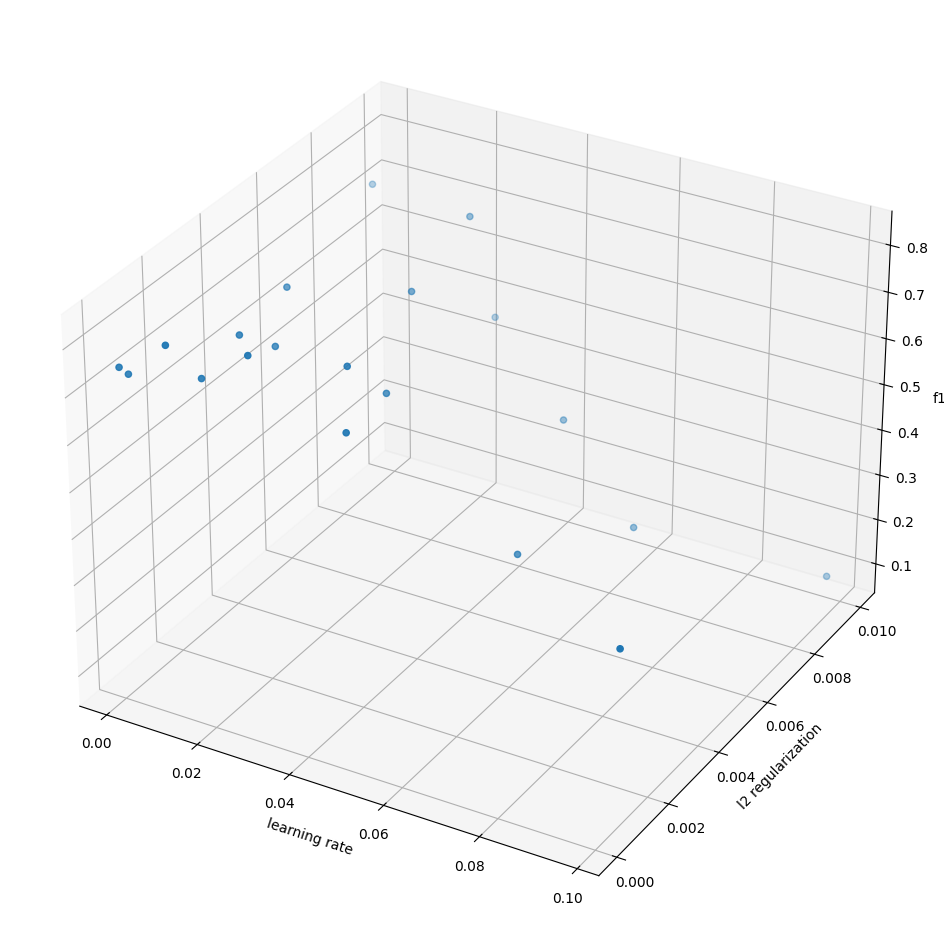

In [24]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(lrs, l2rs, f1s)
ax.set_xlabel('learning rate')
ax.set_ylabel('l2 regularization')
ax.set_zlabel('f1')